# EECE 568 Project: Deep learning and road surface type classification

In this project we explore potential classification methods using mixtures of dashcam video and passive vehicular sensor data(accelerometer, gyroscope) recorded over various  routes containing dirt, cobblestone, and asphalt roads.


**Experiment 1**: Building on a CNN that identifies road type using image frames extracted from dashcam footage, can sensor data be added to the input to augment performance? In other words, for each video frame captured every 10 seconds, additionally use some amount of sensor data measured since the last capture.

_Potential rationale_: Lighting and other obstructions in imagery may contribute to errors

## Imports

In [1]:
%matplotlib inline

import os
import cv2              # video/image processing
import numpy as np      # numpy
import pandas as pd     # data import, analysis, manipulation
import tensorflow as tf # ML framework
import matplotlib.pyplot as plt
import sys
# add as necessary ...

# data structures
from collections import OrderedDict

## Dataset: Passive Vehicular Sensors Datasets
[Kaggle URL](https://www.kaggle.com/datasets/jefmenegazzo/pvs-passive-vehicular-sensors-datasets)

```J. Menegazzo and A. von Wangenheim, "Multi-Contextual and Multi-Aspect Analysis for Road Surface Type Classification Through Inertial Sensors and Deep Learning," 2020 X Brazilian Symposium on Computing Systems Engineering (SBESC), Florianopolis, 2020, pp. 1-8, doi: 10.1109/SBESC51047.2020.9277846.```

This dataset collected by Menegazzo and von Wangenheim contains nine sets of GPS, camera, accelerometer, gyroscope, magnetometer, and temperature sensors collected in nine combinations of three drivers, three vehicles and three different routes around Anita Garibaldi in Brazil. Hardware and sensors are mounted as pictured below:

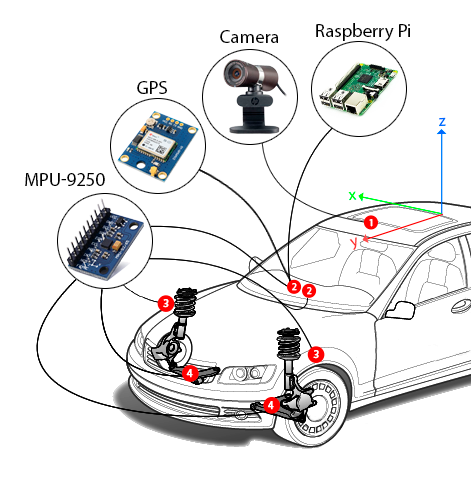

Test if dataset is present and readable

In [2]:
with open('E:/PVS_Datasets/PVS 1/dataset_labels.csv', 'r') as input_file:
    head = [next(input_file) for _ in range(5)]
    input_file.seek(0)  # Reset the file pointer to the start of the file
    line_count = sum(1 for line in input_file)
print(head)
print(line_count)

with open('E:/PVS_Datasets/PVS 1/dataset_gps_mpu_right.csv', 'r') as input_file:
    head = [next(input_file) for _ in range(5)]
    input_file.seek(0)  # Reset the file pointer to the start of the file
    line_count = sum(1 for line in input_file)
print(head)
print(line_count)


['paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right\n', '1,0,0,0,1,1,0,0,1,0,0,1,0,0\n', '1,0,0,0,1,1,0,0,1,0,0,1,0,0\n', '1,0,0,0,1,1,0,0,1,0,0,1,0,0\n', '1,0,0,0,1,1,0,0,1,0,0,1,0,0\n']
144037
['timestamp,acc_x_dashboard,acc_y_dashboard,acc_z_dashboard,acc_x_above_suspension,acc_y_above_suspension,acc_z_above_suspension,acc_x_below_suspension,acc_y_below_suspension,acc_z_below_suspension,gyro_x_dashboard,gyro_y_dashboard,gyro_z_dashboard,gyro_x_above_suspension,gyro_y_above_suspension,gyro_z_above_suspension,gyro_x_below_suspension,gyro_y_below_suspension,gyro_z_below_suspension,mag_x_dashboard,mag_y_dashboard,mag_z_dashboard,mag_x_above_suspension,mag_y_above_suspension,mag_z_above_suspension,temp_dashboard,temp_above_suspension,temp_below_suspension,timestamp_gps,latitude,longitude,speed\n', '1577218796.56,0.314897373

Loading datasets into RAM:

In [3]:
datasets_loc = "E:/PVS_Datasets/"

def getDataSets(n, folder=datasets_loc):
    """Load raw datasets from the disk.

    Args:
        n: Number of datasets to load, from PVS_1, ..., PVS_n
        folder (str): Root folder of PVS datasets. Within this root folder are the PVS folders and their files.

    Returns:
        dict: datasets in a dict form:
        {
            "pvs_n: {
                "left": DataFrame,
                "right": DataFrame,
                "video": VideoCapture,
                "sampled_video": DataFrame, (this is done with extract_frames_to_dataframe)
                "labels": DataFrame
            }
        }
    """

    datasets = {}

    if not 1 <= n <= 9:
      raise ValueError("n must be in [1, 9]")
      return

    for i in range(1, n+1):

        dataset_folder = os.path.join(folder, "PVS " + str(i))

        left =   pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_left.csv'))              #,  float_precision="high" , dtype=np.float32
        right =  pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_right.csv'))             #,  float_precision="high" , dtype=np.float32
        video_path = os.path.join(dataset_folder, 'video_environment.mp4')
        video =  cv2.VideoCapture(video_path)
        labels = pd.read_csv(os.path.join(dataset_folder, 'dataset_labels.csv'), dtype=np.uint8)    #,  float_precision="high"

        datasets["pvs_" + str(i)] = {
            "left": left,
            "right": right,
            "video": video,
            "labels": labels
        }

        print(f"PVS_{i} dataset loaded")

    return datasets

## Options

In [4]:
# labels; one-hot encoded in DataFrames
data_class_labels = ["dirt", "cobblestone", "asphalt"]

# training/validation/test split options
train_pcent = 0.60
val_pcent = 0.20
test_pcent = 0.20

# training and validation batch size
batch_sz = 64

# epochs
epochs = 10

# window parameters
sliding_win = False   # apply windows
win_sz = 100          # number of samples to use per window
# ...

# num datasets to load (PVS_1, ..., PVS_n)
NUM_TO_LOAD = 1
DOWNSCALE_VID = False  # downscale video from 720p to {TBD}
CROP_VID = False       # crop video to center of screen {dimensions TBD}

In [5]:
datasets = getDataSets(NUM_TO_LOAD, datasets_loc)

PVS_1 dataset loaded


## Load an .mp4
Here we need to:

1. Synchronize video and sensor samples in order to match the labels from the original dataset. From [PVS video/data footage](https://www.youtube.com/watch?v=AquJoKyXp1A&list=PLTG6ZC9RiP1dxQk5Wf6UiNxwRyGv-keY7&index=4)
2. Downsample the 30fps dashcam video to  extract frames at 1fps. Store in the dataset dictionary
3. Crop the video frames to the center of the screen that captures the relevant environment; rids of the car hood blocking the lower part of the imagery.


In [6]:
# 1. To sync timestamps for data+video, we note the sample# which matches the start of video
if 'pvs_1' in datasets:
  datasets['pvs_1']['metadata'] = {'video_start': '2019-12-24 17:21:14',
                                  'sample_start': 7743}
if 'pvs_2' in datasets:
  datasets['pvs_2']['metadata'] = {'video_start': '2019-12-24 17:59:54',
                                  'sample_start': 2693}
if 'pvs_3' in datasets:
  datasets['pvs_3']['metadata'] = {'video_start': '2019-12-24 18:37:15',
                                  'sample_start': 6481}
if 'pvs_4' in datasets:
  datasets['pvs_4']['metadata'] = {'video_start': '2019-12-25 17:46:44',
                                  'sample_start': 0}
if 'pvs_5' in datasets:
  datasets['pvs_5']['metadata'] = {'video_start': '2019-12-25 18:17:05',
                                  'sample_start': 1985}
if 'pvs_6' in datasets:
  datasets['pvs_6']['metadata'] = {'video_start': '2019-12-25 18:44:21',
                                  'sample_start': 1013}
if 'pvs_7' in datasets:
  datasets['pvs_7']['metadata'] = {'video_start': '2019-12-26 18:24:10',
                                  'sample_start': 1957}
if 'pvs_8' in datasets:
  datasets['pvs_8']['metadata'] = {'video_start': '2019-12-26 18:51:04',
                                  'sample_start': 626}
if 'pvs_9' in datasets:
  datasets['pvs_9']['metadata'] = {'video_start': '2019-12-26 19:23:32',
                                  'sample_start': 710}
print(datasets['pvs_1'].keys())
print(cv2.CAP_PROP_POS_FRAMES)

dict_keys(['left', 'right', 'video', 'labels', 'metadata'])
1


In [7]:
# crop a frame (in numpy array) with a rectangular box offset from the center of the frame
def center_crop(frame, crop_width, crop_height, vertical_offset=0):
    h, w, _ = frame.shape
    start_x = w // 2 - crop_width // 2
    start_y = h // 2 - crop_height // 2 - vertical_offset
    start_y = max(0, min(h - crop_height, start_y))
    return frame[start_y:start_y+crop_height, start_x:start_x+crop_width]

In [8]:
# 2. Extract frames at 1fps (for memory/speed purposes, downscale video resolution here if needed)

def extract_frames_to_dataframe(pvs_n, dataset, frame_interval=30):

  if pvs_n in datasets:
    cap = dataset[pvs_n]['video']
  else:
    raise ValueError(f'Dataset {pvs_n} not loaded')

  if cap is None or not cap.isOpened():
    raise IOError('Could not open environment_video.mp4')
  cap.set(cv2.CAP_PROP_POS_FRAMES, 0)                    # reset to the first frame

  video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # length of video in frames
  orig_fps = int(cap.get(cv2.CAP_PROP_FPS))              # fps of OG video reported by CV

  print("video_length = ", video_length)
  print("orig_fps = ", orig_fps)
  print("frame_interval = ", frame_interval)

  frames_data = {'frame_no': [], 'timestamp': [], 'frame': [], 
                 'dirt_road': [], 'cobblestone_road': [], 'asphalt_road': []}

  # get start of the data aligned to beginning of video
  offset = datasets[pvs_n]['metadata']['sample_start']
  frame_count = 0
  while cap.isOpened():
    ret, frame_bgr = cap.read()

    if not ret:
      break

    if frame_count % frame_interval == 0:
      time_stamp = cap.get(cv2.CAP_PROP_POS_MSEC)

      cropped_frame_bgr = center_crop(frame_bgr, crop_width=600, crop_height=300, vertical_offset=50)
      cropped_frame_rgb = cv2.cvtColor(cropped_frame_bgr, cv2.COLOR_BGR2RGB)

      sample_no = offset + int(time_stamp / 10.0)
      dirt_label = datasets['pvs_1']['labels'].iloc[sample_no, 2]
      cobble_label = datasets['pvs_1']['labels'].iloc[sample_no, 3]
      asphalt_label = datasets['pvs_1']['labels'].iloc[sample_no, 4]

      frames_data['frame_no'].append(frame_count)
      frames_data['timestamp'].append(time_stamp)
      # frames_data['frame'].append(frame_bgr)
      frames_data['frame'].append(cropped_frame_rgb)
      frames_data['dirt_road'].append(dirt_label)
      frames_data['cobblestone_road'].append(cobble_label)
      frames_data['asphalt_road'].append(asphalt_label)

      sys.stdout.write(f"\r{pvs_n }: {frame_count} / {video_length} frames processed")
      sys.stdout.flush()

    frame_count += 1

  cap.release()

  # Convert the frames_data dictionary to a Pandas DataFrame; replace video
  # dataset[pvs_n]['sampled_video'] = pd.DataFrame(frames_data)
  dataset[pvs_n]['sampled_video'] = frames_data
  num_extracted = len(dataset[pvs_n]['sampled_video']['frame_no'])
  print(f"\n{pvs_n}: Video with total len={video_length} extracted with frame_interval={frame_interval} to {num_extracted} frames\n")


In [9]:
for i in range(1, NUM_TO_LOAD+1):
  extract_frames_to_dataframe(f'pvs_{i}', datasets, frame_interval=10)
print("Done")
print(datasets['pvs_1']['sampled_video'].keys())

video_length =  33090
orig_fps =  24
frame_interval =  10
pvs_1: 70 / 33090 frames processed

pvs_1: 33090 / 33090 frames processed
pvs_1: Video with total len=33090 extracted with frame_interval=10 to 3310 frames

Done
dict_keys(['frame_no', 'timestamp', 'frame', 'dirt_road', 'cobblestone_road', 'asphalt_road'])


In [10]:
video_path = os.path.join("E:/PVS_Datasets/PVS 1/", 'video_environment.mp4')

import subprocess

def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

print(get_length(video_path))

video =  cv2.VideoCapture(video_path)
print(video.get(cv2.CAP_PROP_FRAME_COUNT) // video.get(cv2.CAP_PROP_FPS))

1354.895
1354.0


Show some example frames and associated data:

frame_no: 33090
timestamp: 1354893.213
dirt_road: 0
cobblestone_road: 0
asphalt_road: 1


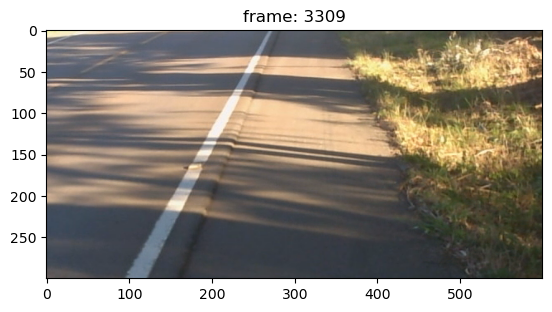

In [11]:
# show some sample frames extracted randomly from dataset, show according labels and past 5 data samples
frame_index = 3309
frame = datasets['pvs_1']['sampled_video']['frame'][frame_index]
plt.figure()
plt.imshow(frame)
plt.title(f"frame: {frame_index}")

print(f"frame_no: {datasets['pvs_1']['sampled_video']['frame_no'][frame_index]}")
print(f"timestamp: {datasets['pvs_1']['sampled_video']['timestamp'][frame_index]}")
print(f"dirt_road: {datasets['pvs_1']['sampled_video']['dirt_road'][frame_index]}")
print(f"cobblestone_road: {datasets['pvs_1']['sampled_video']['cobblestone_road'][frame_index]}")
print(f"asphalt_road: {datasets['pvs_1']['sampled_video']['asphalt_road'][frame_index]}")

## Building a model in Tensorflow

Input data format: tbd


Output format: probabilities length 3

In [12]:
print

<function print>